# SD211  TP3 - Restauration d'image à l'aide de l'ADMM

### Yanting LI

## Introduction

Il s'agit d'un problème de restauration d'image dans le contexte de minimisation à l'aide de l'algorithm ADMM.<br>
Quelques explications:<br>
 - La matrice ${\bf X} \in {\cal R}^{K \times L}$ est l'image 2D original, où K = L = 64. On notera P = K × L le nombre total de pixels dans l'image;<br>
 - ${\bf Y} \in {\cal R}^{K \times L}$ représente l'observation en 2D qui est généré par ${\bf Y} = {\cal H} * {\bf X}$, où ${\cal H} \in {\cal R}^{M \times N}$ est la réponse spatiale du filtre de flou de bougé.<br>
 
Pour exprimer le produit de concolution, on vectorise l'image original et l'observation comme ci dessous:
$${\bf y} = {\bf Hx}$$
 - ${\bf H} \in {\Bbb R}^{P \times P}$ est la matrice de convolution traduisant l'opération de convolution par ${\cal H}$ après vectorisation de l'image.


## 1 Altération d'un image

In [35]:
import pickle
from PIL import Image
import numpy as np
import scipy
import scipy.sparse.linalg as lg
import matplotlib.pyplot as plt
from time import time

{u'H': <4096x4096 sparse matrix of type '<type 'numpy.float64'>'
	with 19722 stored elements in Compressed Sparse Row format>, u'observations': array([[ 0.56867192,  0.58446286,  0.57535565, ...,  0.55947554,
         0.37661705,  0.19865458],
       [ 0.59675915,  0.76867192,  0.73708908, ...,  0.7669988 ,
         0.55947554,  0.37661705],
       [ 0.57205565,  0.79675915,  0.94301477, ...,  0.97633389,
         0.7669988 ,  0.55947554],
       ..., 
       [ 0.54943326,  0.74782435,  0.99921011, ...,  0.77489203,
         0.78214856,  0.58284949],
       [ 0.4       ,  0.54943326,  0.74782435, ...,  0.76602625,
         0.77489203,  0.59992078],
       [ 0.17537371,  0.4       ,  0.54943326, ...,  0.56245907,
         0.56602625,  0.59380954]]), u'T': <8064x4096 sparse matrix of type '<type 'numpy.float64'>'
	with 16128 stored elements in Compressed Sparse Row format>, u'original': array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  

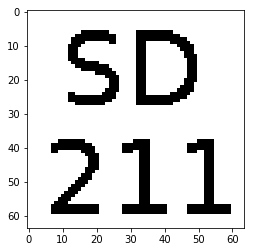

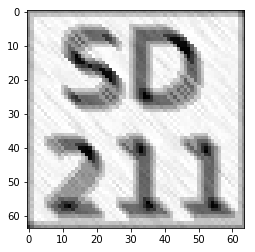

In [36]:
# Open the data stored in a .pk file
data = pickle.load(open('dataforpython2.pk', 'rb'))
print data

H = data.get('H').toarray()
# print "H: ",H
T = data.get('T')
# print T
observations = data.get('observations')
original = data.get('original')

plt.imshow(original, cmap='gray')
plt.show()
plt.imshow(observations, cmap='gray')
plt.show()

## 2 Restauration d'image
Problème:
$$\min_{x}  \frac{1}{2}||{\bf y} -{\bf Hx}||^{2}_{2} + \beta ||{\bf Tx}||_{1} + {\bf \iota}_{[0,1]^{P}}({\bf x})$$

où 
$$||{\bf Tx}||_{1} = \sum_{i,j} (|{\bf X}[i+1,j] - {\bf X}[i,j]| + |{\bf X}[i,j+1] - {\bf X}[i,j]|)$$


La matrice ${\bf T} \in {\Bbb R}^{(2P-K-L)\times P}$ représente les décalages horizontaux et verticaux. 

### Préparation 1
Sachant que 
${\bf z}_{1} = {\bf x}$, ${\bf z}_{2} = {\bf Tx}$ et ${\bf z} = [{\bf z}_{1}^{T}, {\bf z}_{2}^{T}]^{T}$,  pour transformer l'problème ci-dessus à le problème d'optimisation
$$\min_{x} f({\bf x}) + g({\bf z})$$
$$s.t.  {\bf Ax} = {\bf z}$$

On a 

$$f({\bf x}) = \frac{1}{2} ||{\bf y}-{\bf Hx}||^{2}_{2}$$

$$g({\bf z}) = 
    \begin{bmatrix} \iota_{[0,1]^{P}} & 0 \\ 0 & \beta {\bf I}_{(2P−K−L)} \\ \end{bmatrix}
  {\bf z}
$$
où $\iota_{[0,1]^{P}} \in {\cal R}^{P \times P}$
$${\bf z} = {\bf Ax}  $$
$${\bf A} =
\begin{pmatrix} {\bf I}_{P} \\ {\bf T} \\ \end{pmatrix}
$$

### Préparation 2  ????
Le problème (3) s'écrit:<br>
$$\min_{{\bf x}, {\bf z_{2}}} 
  \frac{1}{2}||{\bf y} - {\bf Hx}||^{2}_{2} + \beta ||{\bf z_{2}}||_{1}
  $$
 
$$s.t. {\bf Tx} = {\bf z_{2}}$$

Le Lagrangien augmenté s'écrit:<br>
$$ {\cal L}_{\rho}({\bf x}^{k},{\bf z}_{2}^{k};{\bf \gamma}^{k}) = 
    \frac{1}{2}||{\bf y} - {\bf Hx}||^{2}_{2} + \beta ||{\bf z_{2}}||_{1}
    + <{\bf \gamma}^{k}, {\bf Tx} - {\bf z}_{2}> + \frac{\rho}{2}||{\bf Tx} - {\bf z}_{2}||^{2}_{2}
$$

### Préparation 3
Algorithme ADMM:<br>
$${\bf x}^{k+1} = \arg\min_{\bf x} {\cal L}_{\rho}({\bf x},{\bf z}^{k} , \gamma^{k})$$

$${\bf z}^{k+1} = [{\bf z}^{k+1}_{1}, {\bf z}^{k+1}_{2}]^{T}$$
$$= \arg\min_{\bf z} {\cal L}_{\rho}({\bf x}^{k+1},{\bf z} , \gamma^{k})$$

$${\bf \gamma}^{k+1} = \gamma^{k} + \rho({\bf Ax}^{k+1} - {\bf z}^{k+1})$$

L'étape de minimisation de ${\cal L}_{\rho}$ selon la variable ${\bf x}$:<br>
$$x^{k+1} = \arg\min_{\bf x}  
    f(x) + g(z^{k}) + <\gamma^{k}, Ax-z^{k}> + \frac{\rho}{2}||Ax-z^{k}||^{2}
$$

$$ = \arg\min_{\bf x} \frac{1}{2}||Hx-y||^{2} + <\gamma^{k}, Ax> + \frac{\rho}{2}||Ax-z^{k}||^{2}$$

$$0 = H^{T}(Hx-y) + A^{T}\gamma^{k} + \rho A^{T}(Ax-z^{k})$$

$$\implies x^{k+1} = (H^{T}H + \rho A^{T}A)^{-1} (H^{T}y + \rho A^{T}z^{k} - A^{T}\gamma^{k})$$

### Préparation 4
Pour $z_{1}$:<br>

$$z^{k+1}_{1} = \arg\min_{z_{1}} 
    f(x^{k+1}) + g(z_{1}) + <\gamma_{1}^{k}, I_{P}x^{k+1} - z_{1}> + \frac{\rho}{2}||I_{P}x^{k+1} - z_{1}||^{2}
    $$
$$ = \arg\min_{z_{1}}\iota_{[0,1]^{P}}(z_{1}) - <\gamma_{1}^{k}, z_{1}> + \frac{\rho}{2}||I_{P}x^{k+1} - z_{1}||^{2}$$

$$ = \arg\min_{z_{1}} \frac{\rho}{2} ||z_{1} - x^{k+1}||^{2} - \gamma_{1}^{kT}z_{1} + \iota_{[0,1]^{P}}(z_{1})$$

$$ = \arg\min_{z_{1}} \frac{\rho}{2} ||z_{1} - (x^{k+1} + \frac{\gamma_{1}^{k}}{\rho})||^{2} + \iota_{[0,1]^{P}}(z_{1})$$

$$ = prox_{\frac{1}{\rho} g} (x^{k+1} + \frac{\gamma_{1}^{k}}{\rho})$$

$$ = proj_{\iota_{[0,1]^{P}}} (x^{k+1} + \frac{\gamma_{1}^{k}}{\rho})$$

$$ z^{k+1}_{1} = 
    \begin{cases}
    0,  & \text{if $x^{k+1} + \frac{\gamma_{1}^{k}}{\rho} \leq 0$} \\
    x^{k+1} + \frac{\gamma_{1}^{k}}{\rho}, & \text{if $0 < x^{k+1} + \frac{\gamma_{1}^{k}}{\rho} < 1$} \\
    1,  & \text{if $x^{k+1} + \frac{\gamma_{1}^{k}}{\rho} \geq 1$}
\end{cases}$$

Pour $z_{2}$:<br>
$$z_{2}^{k+1} = \arg\min_{z_{2}} \beta ||z_{2}||_{1}
    + <\gamma_{2}^{k}, z_{2}> + \frac{\rho}{2}||Tx^{k+1} - z_{2}||^{2}_{2}$$
   
$$ = prox_{\frac{1}{\rho} g} (Tx^{k+1} + \frac{\gamma_{2}^{k}}{\rho}) $$
$$= S(Tx^{k+1} + \frac{\gamma_{2}^{k}}{\rho})$$

$$ z^{k+1}_{2} = 
    \begin{cases}
    Tx^{k+1}_{i} + \frac{\gamma_{2 i}^{k}}{\rho} - \beta,  & \text{if $Tx^{k+1}_{i} + \frac{\gamma_{2 i}^{k}}{\rho}> \beta$} \\
    0, & \text{if $Tx^{k+1}_{i} + \frac{\gamma_{2 i}^{k}}{\rho} \in [-\beta, \beta]$} \\
    Tx^{k+1}_{i} + \frac{\gamma_{2 i}^{k}}{\rho} + \beta,  & \text{if $Tx^{k+1}_{i} + \frac{\gamma_{2 i}^{k}}{\rho} < -\beta$}
\end{cases}$$

### Préparation 5
$$\gamma_{1}^{k+1} = \gamma_{1}^{k} + \rho (x^{k+1} - z_{1}^{k+1})$$

$$\gamma_{2}^{k+1} = \gamma_{2}^{k} + \rho (Tx^{k+1} - z_{2}^{k+1})$$


## 3 Implémentation de l'ADMM pour résoudre le problème de restauration d'image
Paramètres de l'ADMM:<br>
 - $\rho = 0.05$
 - $\beta = 0.01$
 - $k_{max} = 100$<br>
 
### Manipulation 2

In [38]:
# Prepare data:
rho = 0.05
beta = 0.01
k_max = 100
# Get the size of the image
K,L = observations.shape
# Observation, Original, T, A:
y = np.ravel(observations)
x_orig = np.ravel(original)
I = np.eye(x_orig.shape[0], dtype=int)
T = data.get('T').toarray()
A = np.vstack((I, T))

In [15]:
# # definie positive?
# C = np.linalg.eigvals(H.T.dot(H) + rho*A.T.dot(A))
# print "La matrice est definie positive: ",np.all(C>0)

La matrice est definie positive:  True


In [41]:
# ADMM:
def ADMM(x0,y,rho=0.05,beta=0.01,k_max=100):
    '''x(4096,)   z1(4096,)   z2(8064,)   z(12160,)'''
    x = []
    z = []
    gamma = []
    EQMs = []
    z1 = x0
    z2 = T.dot(x0)
    gamma1 = np.ones(z1.shape[0])
    gamma2 = np.ones(z2.shape[0])
    gamma_k = np.hstack((gamma1,gamma2))
    for i in range(k_max):
        print i
        z_k = np.hstack((z1,z2))
        x_k = lg.cg((H.T.dot(H) + rho*A.T.dot(A)), (H.T.dot(y)+rho*A.T.dot(z_k)-A.T.dot(gamma_k)))[0]
        EQM = np.mean(x_k - x_orig)
#         EQM = np.mean(np.sum((x-x_orig)**2))
        z1 = proj(x_k + gamma1/rho)
        z2 = Soft(T.dot(x_k) + gamma2/rho, beta)
        z_k = np.hstack((z1,z2))
        gamma1 = gamma1 + rho*(x_k - z1)
        gamma2 = gamma2 + rho*(T.dot(x_k) - z2)
        gamma_k = np.hstack((gamma1,gamma2))
        x.append(x_k)
        z.append(z_k)
        gamma.append(gamma_k)
        EQMs.append(EQM)
    return x,z,gamma,EQMs
        
def proj(x):
    res = np.piecewise(x, [x<0,x>1], [lambda x:0,lambda x:1,lambda x:x])
    return res
    
def Soft(x,beta):
    res = np.piecewise(x, [x>beta,x<-beta], [lambda x:x-beta,lambda x:x+beta,lambda x:0])
    return res

In [42]:
t0 = time()
x0 = np.zeros(x_orig.shape[0])
x_k, z_k, gamma_k, EQMs = ADMM(x0,y,0.05,0.01,100)
run_time = (time() - t0)
print "done in %0.3fs" % run_time

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
done in 396.410s


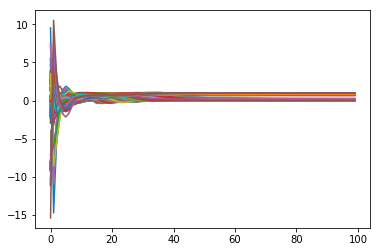

In [43]:
plt.figure()
plt.plot(x_k)
plt.show()

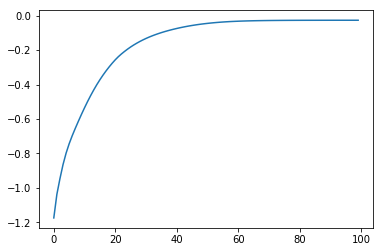

In [46]:
plt.figure()
plt.plot(EQMs)
plt.show()

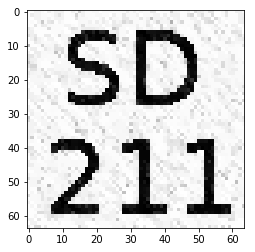

In [59]:
x = x_k[89].reshape((K,L))
plt.imshow(x, cmap='gray')
plt.show()

### Manipulation 4

In [45]:
rhos = np.linspace(0,0.1,6)
print rhos
for rho in rhos:
    

[ 0.    0.02  0.04  0.06  0.08  0.1 ]


In [61]:
t0 = time()
x_k1 = lg.cg((H.T.dot(H) + rho*A.T.dot(A)), (H.T.dot(y)+rho*A.T.dot(z)-A.T.dot(gamma)))
run_time = (time() - t0)
print "done in %0.3fs" % run_time

done in 3.814s


In [62]:
t0 = time()
x_k2 = np.linalg.solve((H.T.dot(H) + rho*A.T.dot(A)), (H.T.dot(y)+rho*A.T.dot(z)-A.T.dot(gamma)))
run_time = (time() - t0)
print "done in %0.3fs" % run_time

done in 4.310s


In [100]:
x = np.linspace(-5,5, 11)
print x
# # def proj(x):
# mask = np.ones(x.shape[0])*(x>=-2)
# print mask
# print x<-2
res = np.piecewise(x, [x<-2,x>2], [lambda x:-2,lambda x:2,lambda x:x])
print res

[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
[-2. -2. -2. -2. -1.  0.  1.  2.  2.  2.  2.]


In [4]:
z_k = z
gamma_k = gamma
print (H.T.dot(H) + rho*A.T.dot(A)).shape
print (H.T.dot(y) + rho*A.T.dot(z_k) - A.T.dot(gamma_k)).shape
print A.T.dot(z).shape
print A.T.dot(gamma_k).shape
x_k1 = lg.cg((H.T.dot(H) + rho*A.T.dot(A)), (H.T.dot(y)+rho*A.T.dot(z)-A.T.dot(gamma)))
print x_k1[0]

(4096, 4096)
(4096,)
(4096,)
(4096,)


NameError: name 'lg' is not defined

### Conclusion (cette conclusion ne doit pas être la copie de l'introduction)